# Statistic and plot

In [102]:
%matplotlib inline
import numpy as np
import json
import seaborn as sns
import pandas as pd


import os
import glob
import SimpleITK as sitk
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
sns.set_style("whitegrid")
from utils.supports import save_json, subfiles, join, maybe_mkdir_p, reconstruct_seg_df_from_json

import numpy as np
import math 
from typing import Tuple


In [103]:
## directorys for summary files
nnunet = "/processing/jintao/medsam_hnc/nii/nnUNet_all"
nnunet_box = "/processing/jintao/medsam_hnc/nii/nnUNet_all_box"

ct_zero = "/processing/jintao/medsam_hnc/nii/HNC_CT/pred_zero"
ct_finetune = "/processing/jintao/medsam_hnc/nii/HNC_CT/pred_finetune"

multimodal_zero = "/processing/jintao/medsam_hnc/nii/HNC_blend/pred_zero_shot"
multimodal_finetune = "/processing/jintao/medsam_hnc/nii/HNC_blend/pred_finetune"

groud_truth = ' /mnt/data/jintao/nnUNet/nnUNet_raw_data_base/nnUNet_raw_data/Task901_AUH/labelsTs/'
images = ' /mnt/data/jintao/nnUNet/nnUNet_raw_data_base/nnUNet_raw_data/Task901_AUH/imagesTs/'

studies = [ct_zero,ct_finetune,multimodal_zero,multimodal_finetune,nnunet,nnunet_box]

In [99]:
groups = [f'CT-only \n zeroshot',f'CT-only \n finetune'
          ,f'Multimodal \n zeroshot',f'Multimodal \n finetune',
          f'nnUNet \n w/o box',f'nnUNet \n w/ box'] #'w/ 3D clicks',  'SAM CT/PET*2',

data_gtv_t = {}
data_gtv_n = {}
for i, study in enumerate(studies):
    gtvt_seg, gtvn_seg  = reconstruct_seg_df_from_json(study)
    #study = study.replace("prob_maps", "u_regions")

    dft = pd.DataFrame.from_dict(gtvt_seg).T
    dfn = pd.DataFrame.from_dict(gtvn_seg).T
    dft['segmentation groups'] = groups[i]
    dfn['segmentation groups'] = groups[i]
    dft.index.names = ['PatientID']
    dfn.index.names = ['PatientID']
    dft= dft.reset_index(drop=False)
    dfn= dfn.reset_index(drop=False)
    
    if i == 0:
        dft_all = dft
        dfn_all = dfn
    else:
        dft_all = pd.concat([dft_all, dft])
        dfn_all = pd.concat([dfn_all, dfn])
        
    data_gtv_t[groups[i]] = dft
    data_gtv_n[groups[i]] = dfn
    

all_seg= pd.concat([dft_all, dfn_all])
all_seg = all_seg.reset_index(drop=True)

In [100]:
print('mean GTV-T DSC')
for i, study in enumerate(groups):
    print(study)
    print(np.round(data_gtv_t[study]['DSC'].mean(),2),'+-', np.round(data_gtv_t[study]['DSC'].std(),2))
    print(len(data_gtv_t[study]['DSC']))
print('===============')
print('mean GTV-N DSC')
for i, study in enumerate(groups):
    print(study)
    print(np.round(data_gtv_n[study]['DSC'].mean(),2), '+-',np.round(data_gtv_n[study]['DSC'].std(),2))
    print(len(data_gtv_n[study]['DSC']))

mean GTV-T DSC
CT-only 
 zeroshot
0.69 +- 0.1
97
CT-only 
 finetune
0.82 +- 0.06
97
Multimodal 
 zeroshot
0.7 +- 0.13
97
Multimodal 
 finetune
0.82 +- 0.07
97
nnUNet 
 w/o box
0.68 +- 0.22
97
nnUNet 
 w/ box
0.88 +- 0.03
97
mean GTV-N DSC
CT-only 
 zeroshot
0.75 +- 0.1
97
CT-only 
 finetune
0.85 +- 0.04
97
Multimodal 
 zeroshot
0.68 +- 0.11
97
Multimodal 
 finetune
0.85 +- 0.05
97
nnUNet 
 w/o box
0.63 +- 0.33
97
nnUNet 
 w/ box
0.89 +- 0.03
97


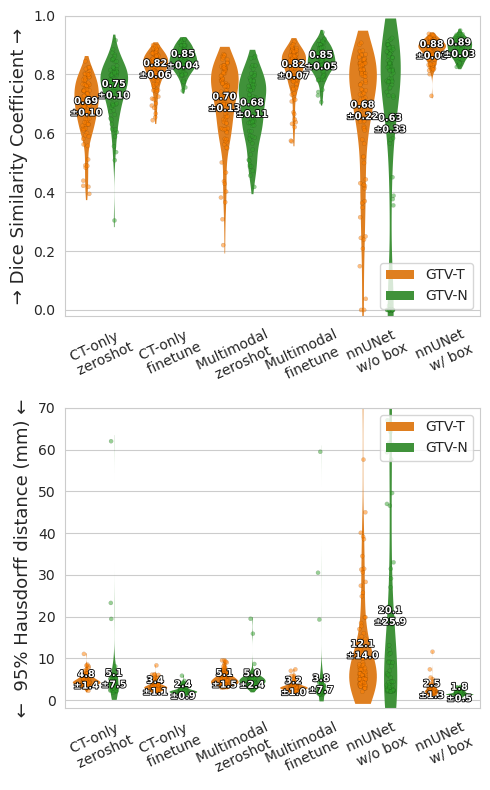

In [101]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import SubplotSpec


# Function to add median labels
def add_median_labels(ax, data, hue_col, y_col, x_col, fmt='.2f', show_std= False):
    for category in data[x_col].unique():
        for hue_level in data[hue_col].unique():
            subset = data[(data[x_col] == category) & (data[hue_col] == hue_level)]
            median = subset[y_col].mean() #median() #
            x_position = ax.get_xticks()[list(data[x_col].unique()).index(category)]
            y_position = median
            std = subset[y_col].std()
            
            # Adjust the x_position for each hue_level so that the text doesn't overlap
            hue_levels = data[hue_col].nunique()
            hue_index = list(data[hue_col].unique()).index(hue_level)
            x_position += (hue_index - (hue_levels - 1) / 2) * 0.4 # Adjust the 0.2 as needed
            if show_std:
                text = ax.text(x_position, y_position, f'{median:{fmt}}\n±{std:{fmt}}',
                        ha='center', va='center', color='white', fontweight='bold', fontsize=7)
            else:
                text = ax.text(x_position, y_position, f'{median:{fmt}}',
                        ha='center', va='center', color='white', fontweight='bold', fontsize=7)
            # Adding a bounding box around the median labels
            text.set_path_effects([
                        path_effects.Stroke(linewidth=1.2, foreground='black'),
                        path_effects.Normal(),
                    ])
            
def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n',size=15)#, fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

# create 3x1 subplots
fig, axs = plt.subplots(2, 1, figsize=(5, 8), sharey=False)
fig.tight_layout()
#fig.suptitle('Figure title')

grid = plt.GridSpec(1, 2)

exp= 'DSC'
y_value = all_seg[exp].astype({exp: float})
sns.violinplot(ax = axs[0], x=all_seg["segmentation groups"], y=y_value,   
            hue =all_seg["GTV"], palette="Paired_r",
                   inner=None,  # Don’t plot the inner dataset
                   linewidth=0,cut=0.5,
                   alpha=0.3).set_ylabel( ' \u2192 Dice Similarity Coefficient \u2192 ', fontsize =13)

sns.stripplot(ax = axs[0], x=all_seg["segmentation groups"], y=y_value,   
              hue =all_seg["GTV"],
              dodge=True, 
              size=3,  # Make points smaller
              edgecolor="k",  # Black outlines
              linewidth=0.1,  # Outline thickness
              palette="Paired_r", 
              alpha=0.5)  # Adjust the opacity with alpha parameter
add_median_labels(axs[0], all_seg, "GTV", exp, "segmentation groups", show_std=True)

exp= 'HD95 (mm)'
y_value = all_seg[exp].astype({exp: float})
sns.violinplot(ax = axs[1], x=all_seg["segmentation groups"], y=y_value,  
            hue =all_seg["GTV"], palette="Paired_r",
                   inner=None,  # Don’t plot the inner dataset
                   linewidth=0,cut=0.5,
                   alpha=0.3).set_ylabel( f' \u2190  95% Hausdorff distance (mm) \u2190 ', fontsize =13)

sns.stripplot(ax = axs[1], x=all_seg["segmentation groups"], y=y_value,   
            hue =all_seg["GTV"],
              dodge=True, 
              size=3,  # Make points smaller
              edgecolor="k",  # Black outlines
              linewidth=0.1,  # Outline thickness
              palette="Paired_r", 
              alpha=0.5)  # Adjust the opacity with alpha parameter
add_median_labels(axs[1], all_seg, "GTV", exp, "segmentation groups", fmt='.1f', show_std=True)

legend_locations = ['lower right', 'upper right', 'upper right']
# Set y-axis limits for each subplot
axs[0].set_ylim(-0.02, 1)     # For the first subplot
axs[1].set_ylim(-2, 70)   # For the second subplot

for i, ax in enumerate(axs):
    ax.set_xticklabels(ax.get_xticklabels(), rotation=25)

    #ax.set_title(subsub_title_list[i],  y=1.05)

    # Get the handles and labels of the violinplot (first plot that was created)
    handles, labels = ax.get_legend_handles_labels()
    
    # If there are duplicate labels (due to swarmplot), get only the first set of handles and labels
    handles, labels = handles[:len(labels)//2], labels[:len(labels)//2]
    ax.legend(handles, labels, loc=legend_locations[i])
    
    ax.set_xlabel('')
    
    # Get the maximum y-value to place the significance markers above the violins
    y_max = ax.get_ylim()[1]
    
fig.tight_layout()
fig.savefig('plot.png', dpi=300)
plt.show()

In [104]:
all_seg[all_seg['PatientID']=='HNCDL_115']


,PatientID,Accuracy,Mean Surface Distance (mm),DSC,False Discovery Rate,False Negative Rate,False Omission Rate,False Positive Rate,HD95 (mm),Jaccard,...,Precision,Recall,Surface Dice 1mm,Surface Dice 2mm,Surface Dice 3mm,Volume (cc),Pred Volume (cc),True Negative Rate,GTV,segmentation groups
20,HNCDL_115,0.999264,2.674993,0.600822,0.406834,0.391321,0.000356,0.00038,6.164414,0.429411,...,0.593166,0.608679,0.459587,0.616287,0.758211,15.49,15.89,0.99962,GTV-T,CT-only \n zeroshot
117,HNCDL_115,0.998829,1.267486,0.806084,0.25477,0.122239,0.00034,0.000834,3.741657,0.67516,...,0.74523,0.877761,0.678265,0.826575,0.93209,15.49,18.24,0.999166,GTV-T,CT-only \n finetune
214,HNCDL_115,0.999448,1.957541,0.698657,0.306346,0.296268,0.00027,0.000283,4.690416,0.536874,...,0.693654,0.703732,0.485503,0.660884,0.83597,15.49,15.71,0.999717,GTV-T,Multimodal \n zeroshot
311,HNCDL_115,0.99971,0.870746,0.841639,0.163488,0.153171,0.000139,0.000151,3.0,0.726578,...,0.836512,0.846829,0.751057,0.900131,0.977339,15.49,15.68,0.999849,GTV-T,Multimodal \n finetune
408,HNCDL_115,0.999561,1.269673,0.738469,0.194646,0.318158,0.00029,0.00015,7.28011,0.585375,...,0.805354,0.681842,0.498201,0.690396,0.827079,15.49,13.11,0.99985,GTV-T,nnUNet \n w/o box
505,HNCDL_115,0.999741,0.81075,0.868536,0.193502,0.059086,0.000054,0.000205,2.828427,0.767622,...,0.806498,0.940914,0.802785,0.922956,0.981405,15.49,18.07,0.999795,GTV-T,nnUNet \n w/ box
602,HNCDL_115,0.999666,0.855561,0.866015,0.05425,0.20132,0.000273,0.000062,2.44949,0.763692,...,0.94575,0.79868,0.786693,0.940122,0.987535,23.03,19.45,0.999938,GTV-N,CT-only \n zeroshot
699,HNCDL_115,0.999169,0.706271,0.899639,0.104752,0.095927,0.000397,0.000438,2.0,0.817586,...,0.895248,0.904073,0.884198,0.970575,0.992676,23.03,23.26,0.999562,GTV-N,CT-only \n finetune
796,HNCDL_115,0.999348,1.719265,0.792547,0.304318,0.079251,0.000107,0.000545,4.123106,0.656379,...,0.695682,0.920749,0.562681,0.760872,0.900883,23.03,30.48,0.999455,GTV-N,Multimodal \n zeroshot
893,HNCDL_115,0.999727,0.707471,0.899841,0.106895,0.093321,0.000126,0.000147,2.0,0.817918,...,0.893105,0.906679,0.872518,0.970462,0.995442,23.03,23.38,0.999853,GTV-N,Multimodal \n finetune
